In [36]:
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio as rio
import rasterio.mask as rio_mask
from rasterio.crs import CRS

import seaborn as sns

import os
from typing import Tuple

In [68]:
fp_watersheds = os.path.relpath("../datasets/watershed_bounds/basin24/basin24.shp")
stream_gage_watersheds_fp = os.path.relpath("../datasets/stream_gages/site_watersheds.geojson")
watersheds_out_fp = os.path.relpath("../datasets/out/watersheds_impermeability.geojson")
stream_gage_watersheds_out_fp = os.path.relpath("../datasets/out/stream_gage_watersheds_impermeability.geojson")

In [38]:
area_names = ["croton_outer", "catskill_delaware_outer"]
start_year = 1985
end_year = 2024
collection_year_range = range(start_year, end_year + 1, 1)
# simply because I can't figure out a better way to do this >_<
decadal_stops = range(start_year + 9, 10, end_year+1)
file_type_dic = {
  "Land Cover": "LndCov",
  "Land Cover Change": "LndChg",
  "Land Cover Confidence": "LndCnf",
  "Fractional Impervious Surface": "FctImp",
  "Impervious Descriptor": "ImpDsc",
  "Spectral Change Day of Year": "SpcChg"
}
nlcd_annual_fname_template = "Annual_NLCD_{file_type}_{year}_CU_C1V1.tiff"
nlcd_annual_fractional_impervious_change_template = "Annual_NLCD_FctImp_{from_year}_{to_year}_CU_C1V1.tiff"

landcover_dir = os.path.relpath("../datasets/landcover")
nlcd_landcover_dir = os.path.join(landcover_dir, "nlcd_annual")
fractional_impervious_dir = fractional_impervious_change_dir = os.path.join(landcover_dir, "fractional_impervious")
fractional_impervious_change_dir = os.path.join(fractional_impervious_dir, "change")

valid_data_def_dict = {
  "Land Cover": {"valid_range": pd.Interval(closed="both", left=11, right=95), "no_data": 250},
  "Land Cover Change": {"valid_range": pd.Interval(closed="both", left=11, right=9590), "no_data": 9999},
  "Land Cover Confidence": {"valid_range": pd.Interval(closed="both", left=1, right=100), "no_data": 250},
  "Fractional Impervious Surface": {"valid_range": pd.Interval(closed="both", left=0, right=100), "no_data": 250},
  "Impervious Descriptor": {"valid_range": pd.Interval(closed="both", left=0, right=2), "no_data": 250},
  "Spectral Change Day of Year": {"valid_range": pd.Interval(closed="both", left=0, right=366), "no_data": 9999},
}

In [39]:
catskill_delaware_reservoirs = ["cannonsville", "schoharie", "pepacton", "ashokan", "neversink", "rondout"]
fractional_impervious_watershed_dir = os.path.join(fractional_impervious_dir, "watersheds")
watershed_fname_template = "Annual_NLCD_FctImp_{watershed_name}_{year}_CU_C1V1.tiff"

canonical_crs = CRS.from_epsg(4326)

In [40]:
def is_catskill_delaware_watershed(basin_name: str) -> bool:
  return basin_name.lower() in catskill_delaware_reservoirs

def get_watershed_area_name(basin_name: str) -> str:
  return area_names[1] if is_catskill_delaware_watershed(basin_name=basin_name) else area_names[0]

def get_canonical_watershed_str(basin_name: str) -> str:
  # assume that there aren't special chars, otherwise we'd need to substitute
   return "_".join(basin_name.lower().split())

def get_yearly_raster_for_watershed_fname(basin_name: str, file_type: str = file_type_dic["Fractional Impervious Surface"], year: int = start_year) -> Tuple[str, str]:
  canonical_name = get_canonical_watershed_str(basin_name=basin_name)
  watershed_dir = os.path.join(fractional_impervious_watershed_dir, canonical_name)
  return (watershed_dir, watershed_fname_template.format(watershed_name=canonical_name, year=year))

In [50]:
watersheds_gdf = gpd.read_file(fp_watersheds).to_crs(canonical_crs)
stream_gage_watersheds_gdf = gpd.read_file(stream_gage_watersheds_fp).to_crs(canonical_crs)

stream_gage_watersheds_gdf["BASIN"] = stream_gage_watersheds_gdf["basin_name"]
stream_gage_watersheds_gdf["basin_name"] = stream_gage_watersheds_gdf["BASIN"] + " " + stream_gage_watersheds_gdf["site_no"]
stream_gage_watersheds_gdf["watershed_area"] = stream_gage_watersheds_gdf["BASIN"].apply(get_watershed_area_name)
watersheds_gdf["basin_name"] = watersheds_gdf["BASIN"]
watersheds_gdf["watershed_area"] = watersheds_gdf["BASIN"].apply(get_watershed_area_name)

# add space for years
num_watersheds = watersheds_gdf.shape[0]
watersheds_gdf = watersheds_gdf.loc[watersheds_gdf.index.repeat(len(collection_year_range))]
watersheds_gdf["year"] = list(collection_year_range) * num_watersheds
num_watersheds = stream_gage_watersheds_gdf.shape[0]
gages_basins_gdf = stream_gage_watersheds_gdf.loc[stream_gage_watersheds_gdf.index.repeat(len(collection_year_range))]
gages_basins_gdf["year"] = list(collection_year_range) * num_watersheds
gages_basins_gdf

,site_no,basin_name,area_sq_miles,geometry,BASIN,watershed_area,year
0,01349700,Schoharie 01349700,36.245518,"POLYGON ((-74.09025 42.25915, -74.08524 42.258...",Schoharie,catskill_delaware_outer,1985
0,01349700,Schoharie 01349700,36.245518,"POLYGON ((-74.09025 42.25915, -74.08524 42.258...",Schoharie,catskill_delaware_outer,1986
0,01349700,Schoharie 01349700,36.245518,"POLYGON ((-74.09025 42.25915, -74.08524 42.258...",Schoharie,catskill_delaware_outer,1987
0,01349700,Schoharie 01349700,36.245518,"POLYGON ((-74.09025 42.25915, -74.08524 42.258...",Schoharie,catskill_delaware_outer,1988
0,01349700,Schoharie 01349700,36.245518,"POLYGON ((-74.09025 42.25915, -74.08524 42.258...",Schoharie,catskill_delaware_outer,1989
...,...,...,...,...,...,...,...
67,01435900,Neversink 01435900,92.465974,"POLYGON ((-74.63862 41.82174, -74.64034 41.823...",Neversink,catskill_delaware_outer,2020
67,01435900,Neversink 01435900,92.465974,"POLYGON ((-74.63862 41.82174, -74.64034 41.823...",Neversink,catskill_delaware_outer,2021
67,01435900,Neversink 01435900,92.465974,"POLYGON ((-74.63862 41.82174, -74.64034 41.823...",Neversink,catskill_delaware_outer,2022
67,01435900,Neversink 01435900,92.465974,"POLYGON ((-74.63862 41.82174, -74.64034 41.823...",Neversink,catskill_delaware_outer,2023


In [58]:
# we have a custom crs on our rasters, different for the different watersheds
# project the relevant data to that crs
# a good reason to just get a larger, all-encompassing raster from MRLC
catskill_raster_path = os.path.relpath("../datasets/landcover/nlcd_annual/catskill_delaware_outer/Annual_NLCD_FctImp_1985_CU_C1V1.tiff")
with rio.open(catskill_raster_path) as src:
  catskill_meta = src.meta

croton_raster_path = os.path.relpath("../datasets/landcover/nlcd_annual/croton_outer/Annual_NLCD_FctImp_1985_CU_C1V1.tiff")
with rio.open(croton_raster_path) as src:
  croton_meta = src.meta

catskill_reservoir_mask = watersheds_gdf["watershed_area"] == "catskill_delaware_outer"
catskill_reservoirs = watersheds_gdf[catskill_reservoir_mask].to_crs(catskill_meta["crs"])
croton_reservoirs = watersheds_gdf[~catskill_reservoir_mask].to_crs(croton_meta["crs"])

catskill_gage_mask = gages_basins_gdf["watershed_area"] == "catskill_delaware_outer"
catskill_gages = gages_basins_gdf[catskill_gage_mask].to_crs(catskill_meta["crs"])
croton_gages = gages_basins_gdf[~catskill_gage_mask].to_crs(croton_meta["crs"])
croton_gages

,site_no,basin_name,area_sq_miles,geometry,BASIN,watershed_area,year
30,0137449480,East Branch 0137449480,62.664556,"POLYGON ((1843237.031 2265759.375, 1842947.344...",East Branch,croton_outer,1985
30,0137449480,East Branch 0137449480,62.664556,"POLYGON ((1843237.031 2265759.375, 1842947.344...",East Branch,croton_outer,1986
30,0137449480,East Branch 0137449480,62.664556,"POLYGON ((1843237.031 2265759.375, 1842947.344...",East Branch,croton_outer,1987
30,0137449480,East Branch 0137449480,62.664556,"POLYGON ((1843237.031 2265759.375, 1842947.344...",East Branch,croton_outer,1988
30,0137449480,East Branch 0137449480,62.664556,"POLYGON ((1843237.031 2265759.375, 1842947.344...",East Branch,croton_outer,1989
...,...,...,...,...,...,...,...
43,01374941,Muscoot 01374941,19.600007,"POLYGON ((1829189.062 2251288.828, 1828465.312...",Muscoot,croton_outer,2020
43,01374941,Muscoot 01374941,19.600007,"POLYGON ((1829189.062 2251288.828, 1828465.312...",Muscoot,croton_outer,2021
43,01374941,Muscoot 01374941,19.600007,"POLYGON ((1829189.062 2251288.828, 1828465.312...",Muscoot,croton_outer,2022
43,01374941,Muscoot 01374941,19.600007,"POLYGON ((1829189.062 2251288.828, 1828465.312...",Muscoot,croton_outer,2023


In [59]:
# write fractional_impervious raster for each watershed for each year
fractional_impervious_file_type = file_type_dic["Fractional Impervious Surface"]
for _, watershed in pd.concat([croton_reservoirs, catskill_reservoirs, croton_gages, catskill_gages]).iterrows():
  watershed_area = watershed.watershed_area
  year = int(watershed.year)
  out_dir, out_fname = get_yearly_raster_for_watershed_fname(basin_name=watershed.basin_name, year=year)
  print(watershed.basin_name, year)
  if os.path.isdir(out_dir) != True:
    os.mkdir(out_dir)

  out_path = os.path.join(out_dir, out_fname)

  input_raster_fname = nlcd_annual_fname_template.format(file_type=fractional_impervious_file_type, year=year)
  input_raster_path = os.path.join(nlcd_landcover_dir, watershed_area, input_raster_fname)
  with rio.open(input_raster_path) as src:
    out_img, out_transform = rio_mask.mask(src, [watershed.geometry], crop=True)
    out_meta = src.meta
  
  out_meta.update({
    "height": out_img.shape[1],
    "width": out_img.shape[2],
    "transform": out_transform,
  })

  with rio.open(out_path, "w", **out_meta) as dst:
    dst.write(out_img)

Lake Gleneida 1985
Lake Gleneida 1986
Lake Gleneida 1987
Lake Gleneida 1988
Lake Gleneida 1989
Lake Gleneida 1990
Lake Gleneida 1991
Lake Gleneida 1992
Lake Gleneida 1993
Lake Gleneida 1994
Lake Gleneida 1995
Lake Gleneida 1996
Lake Gleneida 1997
Lake Gleneida 1998
Lake Gleneida 1999
Lake Gleneida 2000
Lake Gleneida 2001
Lake Gleneida 2002
Lake Gleneida 2003
Lake Gleneida 2004
Lake Gleneida 2005
Lake Gleneida 2006
Lake Gleneida 2007
Lake Gleneida 2008
Lake Gleneida 2009
Lake Gleneida 2010
Lake Gleneida 2011
Lake Gleneida 2012
Lake Gleneida 2013
Lake Gleneida 2014
Lake Gleneida 2015
Lake Gleneida 2016
Lake Gleneida 2017
Lake Gleneida 2018
Lake Gleneida 2019
Lake Gleneida 2020
Lake Gleneida 2021
Lake Gleneida 2022
Lake Gleneida 2023
Lake Gleneida 2024
Cross River 1985
Cross River 1986
Cross River 1987
Cross River 1988
Cross River 1989
Cross River 1990
Cross River 1991
Cross River 1992
Cross River 1993
Cross River 1994
Cross River 1995
Cross River 1996
Cross River 1997
Cross River 1998
Cr

In [61]:
def calculate_impervious_fraction_for_watershed(shape, basin_name: str, year: int = start_year) -> np.float64:
  # retrieve the correct file
  in_dir, in_fname = get_yearly_raster_for_watershed_fname(basin_name=basin_name, year=year)
  raster_fp = os.path.join(in_dir, in_fname)
  with rio.open(raster_fp) as src:
    data = src.read(1)
    meta = src.meta
  
  nodata = np.uint8(meta["nodata"])
  
  valid_interval = valid_data_def_dict["Fractional Impervious Surface"]["valid_range"]
  m = (data != nodata)
  valid_cells = m.sum()
  fractional_impervious = data.sum(where=m)

  # resolution is 30m2
  valid_area = valid_cells*30*30
  impervious_area = (fractional_impervious*30*30)/100
  total_fractional_impervious = impervious_area/valid_area

  return np.float64(total_fractional_impervious)

In [63]:
watersheds_gdf["impervious_fraction"] = watersheds_gdf.apply(lambda x: calculate_impervious_fraction_for_watershed(shape=x.geometry, basin_name=x.BASIN, year=x.year), axis=1 )

gages_basins_gdf["impervious_fraction"] = gages_basins_gdf.apply(lambda x: calculate_impervious_fraction_for_watershed(shape=x.geometry, basin_name=x.basin_name, year=x.year), axis=1 )
gages_basins_gdf

,site_no,basin_name,area_sq_miles,geometry,BASIN,watershed_area,year,impervious_fraction
0,01349700,Schoharie 01349700,36.245518,"POLYGON ((-74.09025 42.25915, -74.08524 42.258...",Schoharie,catskill_delaware_outer,1985,0.005008
0,01349700,Schoharie 01349700,36.245518,"POLYGON ((-74.09025 42.25915, -74.08524 42.258...",Schoharie,catskill_delaware_outer,1986,0.005011
0,01349700,Schoharie 01349700,36.245518,"POLYGON ((-74.09025 42.25915, -74.08524 42.258...",Schoharie,catskill_delaware_outer,1987,0.005037
0,01349700,Schoharie 01349700,36.245518,"POLYGON ((-74.09025 42.25915, -74.08524 42.258...",Schoharie,catskill_delaware_outer,1988,0.005044
0,01349700,Schoharie 01349700,36.245518,"POLYGON ((-74.09025 42.25915, -74.08524 42.258...",Schoharie,catskill_delaware_outer,1989,0.005106
...,...,...,...,...,...,...,...,...
67,01435900,Neversink 01435900,92.465974,"POLYGON ((-74.63862 41.82174, -74.64034 41.823...",Neversink,catskill_delaware_outer,2020,0.003262
67,01435900,Neversink 01435900,92.465974,"POLYGON ((-74.63862 41.82174, -74.64034 41.823...",Neversink,catskill_delaware_outer,2021,0.003268
67,01435900,Neversink 01435900,92.465974,"POLYGON ((-74.63862 41.82174, -74.64034 41.823...",Neversink,catskill_delaware_outer,2022,0.003268
67,01435900,Neversink 01435900,92.465974,"POLYGON ((-74.63862 41.82174, -74.64034 41.823...",Neversink,catskill_delaware_outer,2023,0.003271


<Axes: xlabel='year', ylabel='impervious_fraction'>

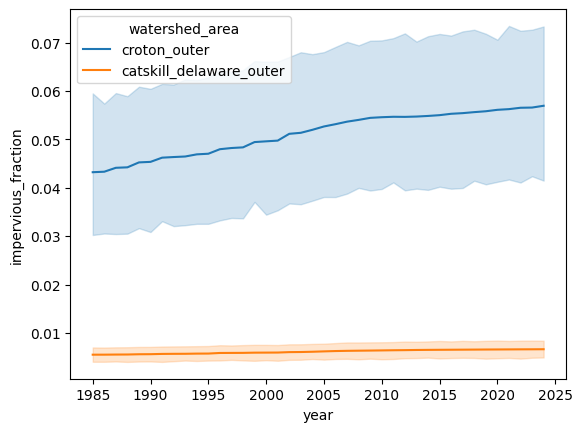

In [66]:
sns.lineplot(data=watersheds_gdf, x="year", y="impervious_fraction", hue="watershed_area")

<Axes: xlabel='year', ylabel='impervious_fraction'>

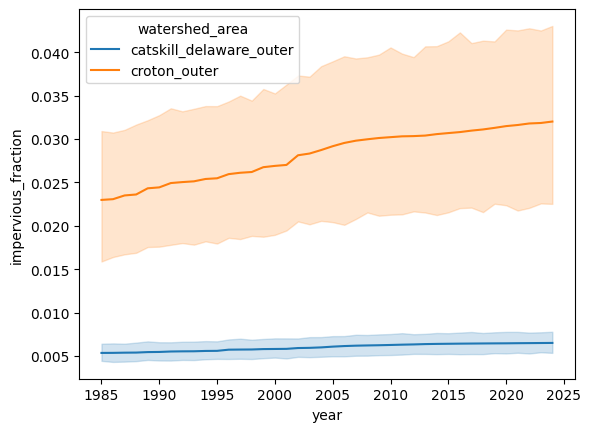

In [67]:
sns.lineplot(data=gages_basins_gdf, x="year", y="impervious_fraction", hue="watershed_area")

In [69]:
watersheds_gdf.to_file(watersheds_out_fp)
gages_basins_gdf.to_file(stream_gage_watersheds_out_fp)